In [1]:
# python
from tqdm.notebook import tqdm
import sys
import os
import importlib
# columnar analysis
import awkward as ak
import mplhep as hep
import numpy as np
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from sidm.tools import ffschema, sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
import vector
import numpy as np
from scipy import stats
from scipy.stats import expon
from scipy.optimize import differential_evolution

In [2]:
samples_off = [
    "2Mu2E_500GeV_0p25GeV_0p004mm",
    "2Mu2E_500GeV_0p25GeV_0p04mm",
    "2Mu2E_500GeV_0p25GeV_0p4mm",
    "2Mu2E_500GeV_0p25GeV_2mm",
    "2Mu2E_500GeV_0p25GeV_4mm",
    
    "2Mu2E_500GeV_1p2GeV_0p019mm",
    "2Mu2E_500GeV_1p2GeV_0p19mm",
    "2Mu2E_500GeV_1p2GeV_1p9mm",
    "2Mu2E_500GeV_1p2GeV_9p6mm",
    "2Mu2E_500GeV_1p2GeV_19mm",
    
    '2Mu2E_500GeV_5GeV_0p08mm',
    '2Mu2E_500GeV_5GeV_0p8mm',
    '2Mu2E_500GeV_5GeV_8mm',
    '2Mu2E_500GeV_5GeV_40mm',
    '2Mu2E_500GeV_5GeV_80mm',
]

In [4]:
samples_pri = [
    
    "4Mu_500GeV_0p25GeV_0p004mm",
    "4Mu_500GeV_0p25GeV_0p04mm",
    "4Mu_500GeV_0p25GeV_0p4mm",
    "4Mu_500GeV_0p25GeV_2mm",
    "4Mu_500GeV_0p25GeV_4mm",
    
    "4Mu_500GeV_1p2GeV_0p019mm",
    "4Mu_500GeV_1p2GeV_0p19mm",
    "4Mu_500GeV_1p2GeV_1p9mm",
    "4Mu_500GeV_1p2GeV_9p6mm",
    "4Mu_500GeV_1p2GeV_19mm",
    
    '4Mu_500GeV_5GeV_0p08mm',
    '4Mu_500GeV_5GeV_0p8mm',
    '4Mu_500GeV_5GeV_8mm',
    '4Mu_500GeV_5GeV_40mm',
    '4Mu_500GeV_5GeV_80mm',
]

In [3]:
fileset_off = utilities.make_fileset(samples_off, "ffntuple_v4")
#fileset_pri = utilities.make_fileset(samples_pri, "ffntuple_v2")

events_off, events_pri = {}, {}

for i in tqdm(samples_off):
    fname = fileset_off[i][0]
    print(fname)
    events_off[i] = NanoEventsFactory.from_root(
        fname,
        treepath='ffNtuplizer/ffNtuple',
        schemaclass=ffschema.FFSchema,
    ).events()

  0%|          | 0/15 [00:00<?, ?it/s]

root://xcache//store/group/lpcmetx/SIDM/ffNtupleV4/2018/SIDM_XXTo2ATo2Mu2E_mXX-500_mA-0p25_ctau-0p004_TuneCP5_13TeV-madgraph-pythia8/RunIIAutumn18DRPremix-102X_upgrade2018_realistic_v15-v1/210326_153213/0000/ffNtuple_1.root
root://xcache//store/group/lpcmetx/SIDM/ffNtupleV4/2018/SIDM_XXTo2ATo2Mu2E_mXX-500_mA-0p25_ctau-0p04_TuneCP5_13TeV-madgraph-pythia8/RunIIAutumn18DRPremix-102X_upgrade2018_realistic_v15-v1/210326_153648/0000/ffNtuple_1.root
root://xcache//store/group/lpcmetx/SIDM/ffNtupleV4/2018/SIDM_XXTo2ATo2Mu2E_mXX-500_mA-0p25_ctau-0p4_TuneCP5_13TeV-madgraph-pythia8/RunIIAutumn18DRPremix-102X_upgrade2018_realistic_v15-v1/210326_161225/0000/ffNtuple_1.root
root://xcache//store/group/lpcmetx/SIDM/ffNtupleV4/2018/SIDM_XXTo2ATo2Mu2E_mXX-500_mA-0p25_ctau-2_TuneCP5_13TeV-madgraph-pythia8/RunIIAutumn18DRPremix-102X_upgrade2018_realistic_v15-v1/210326_160236/0000/ffNtuple_1.root
root://xcache//store/group/lpcmetx/SIDM/ffNtupleV4/2018/SIDM_XXTo2ATo2Mu2E_mXX-500_mA-0p25_ctau-4_TuneCP5_13TeV

In [4]:
fileset_pri = utilities.make_fileset(samples_pri, "ffntuple_v2")
for i in tqdm(samples_pri):
    fname = fileset_pri[i][0]
    print(fname)
    events_pri[i] = NanoEventsFactory.from_root(
        fname,
        treepath='ffNtuplizer/ffNtuple',
        schemaclass=ffschema.FFSchema,
    ).events()

NameError: name 'samples_pri' is not defined

In [5]:
def extract_values(events, sample):
    
    masked_gen = events["{0}".format(sample)].gen[(abs(events["{0}".format(sample)].gen.pid) == 32) & (abs(events["{0}".format(sample)].gen.daupid) == 13)]
    
    masked_gen_vec = vector.zip({
        "px": masked_gen.x,
        "py": masked_gen.y,
        "pz": masked_gen.z,
        "e": masked_gen.t})
    
    masked_gen_vec_x = masked_gen_vec.x
    masked_gen_vec_y = masked_gen_vec.y
    masked_gen_vec_z = masked_gen_vec.z
    masked_gen_vec_t = masked_gen_vec.t
    
    rho = ak.flatten((masked_gen.dauvtx - masked_gen.vtx).rho)
    gamma = ak.flatten(masked_gen_vec.gamma)
    beta = ak.flatten(masked_gen_vec.beta)
    
    return rho, gamma, beta

In [6]:
def plotting_2mu2e(events, sample, ranges, i, j, co):
    
    plt_range = (0, ranges)
    
    rho, gamma, beta = extract_values(events, sample)
    
    lxyz_gb = rho/(gamma * beta)
    P = stats.expon.fit(lxyz_gb)
    
    ax[i][j].hist(lxyz_gb, range=plt_range, linewidth=3, bins=100, histtype='step', label=sample+"_V4", density=True, color=co)
    ax[i][j].plot(np.linspace(*plt_range,100), stats.expon.pdf(np.linspace(*plt_range,100), *P), label=fr"exp[ -(x - {P[0]:.3e}) / {P[1]:.3e} ] / {P[1]:.3e}", color='black')
    ax[i][j].set_yscale("log")
    ax[i][j].legend(fontsize=18)
    ax[i][j].set_xlabel(r"$L_{xyz}$/$\beta\gamma$")

In [ ]:
def plotting_4mu(events, sample, ranges, i, j, co):
    
    plt_range = (0, ranges)
    
    rho, gamma, beta = extract_values(events, sample)
    
    lxyz_gb = rho/(gamma * beta)
    P = stats.expon.fit(lxyz_gb)
    
    ax[i][j].hist(lxyz_gb, range=plt_range, linewidth=3, bins=100, histtype='step', label=sample+"_V2", density=True, color=co)
    ax[i][j].plot(np.linspace(*plt_range,100), stats.expon.pdf(np.linspace(*plt_range,100), *P), label=fr"exp[ -(x - {P[0]:.3e}) / {P[1]:.3e} ] / {P[1]:.3e}", color='black')
    ax[i][j].set_yscale("log")
    ax[i][j].legend(fontsize=18)
    ax[i][j].set_xlabel(r"$L_{xyz}$/$\beta\gamma$")

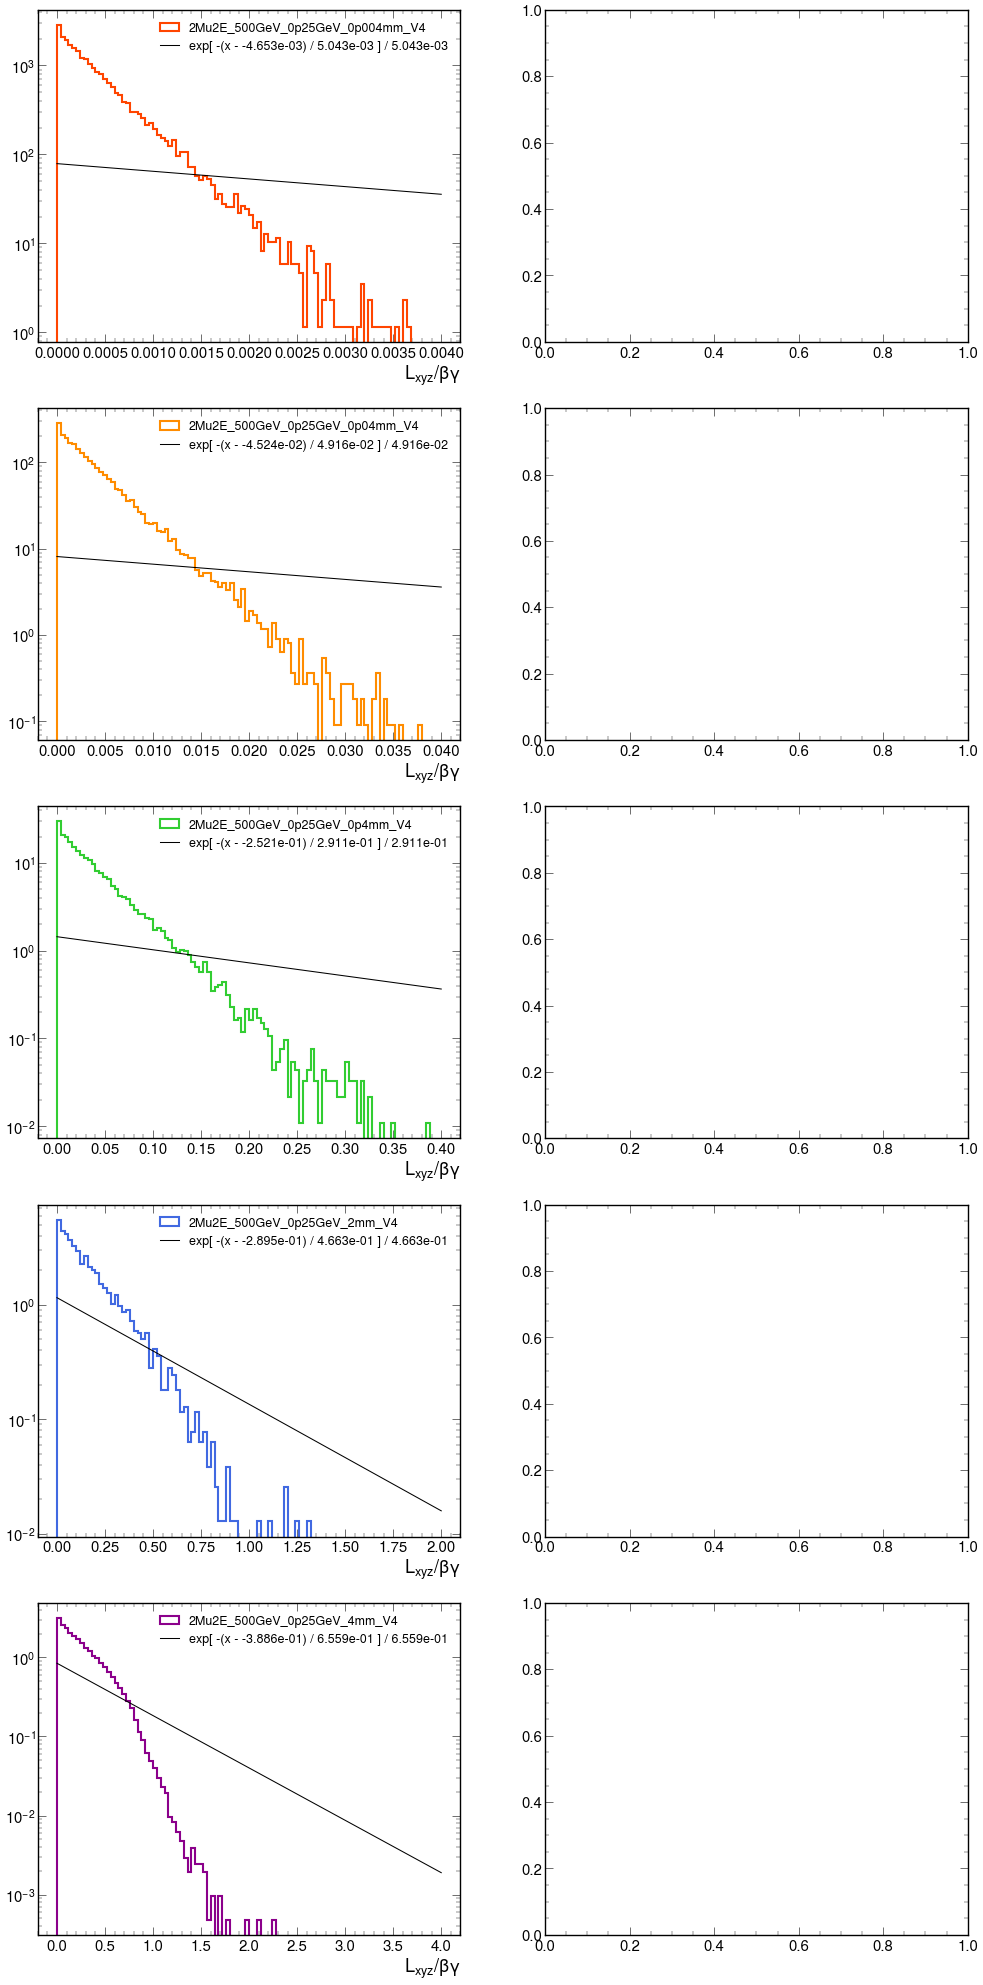

In [13]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(5, 2, figsize=(24, 50)) 

plotting_2mu2e(events_off, "2Mu2E_500GeV_0p25GeV_0p004mm", 0.004,0,0, "orangered")
#plotting_4mu(events_pri, "4Mu_500GeV_0p25GeV_0p004mm", 0.08,0,1, "orangered")

plotting_2mu2e(events_off, "2Mu2E_500GeV_0p25GeV_0p04mm", 0.04,1,0, "darkorange")
#plotting_4mu(events_pri, "4Mu_500GeV_0p25GeV_0p04mm", 0.8,1,1, "darkorange")

plotting_2mu2e(events_off, "2Mu2E_500GeV_0p25GeV_0p4mm", 0.4,2,0, "limegreen")
#plotting_4mu(events_pri, "4Mu_500GeV_0p25GeV_0p4mm", 8,2,1, "limegreen")

plotting_2mu2e(events_off, "2Mu2E_500GeV_0p25GeV_2mm", 2,3,0, "royalblue")
#plotting_4mu(events_pri, "4Mu_500GeV_0p25GeV_2mm", 40,3,1, "royalblue")

plotting_2mu2e(events_off, "2Mu2E_500GeV_0p25GeV_4mm", 4,4,0, "darkmagenta")
#plotting_4mu(events_pri, "4Mu_500GeV_0p25GeV_4mm", 80,4,1, "darkmagenta")

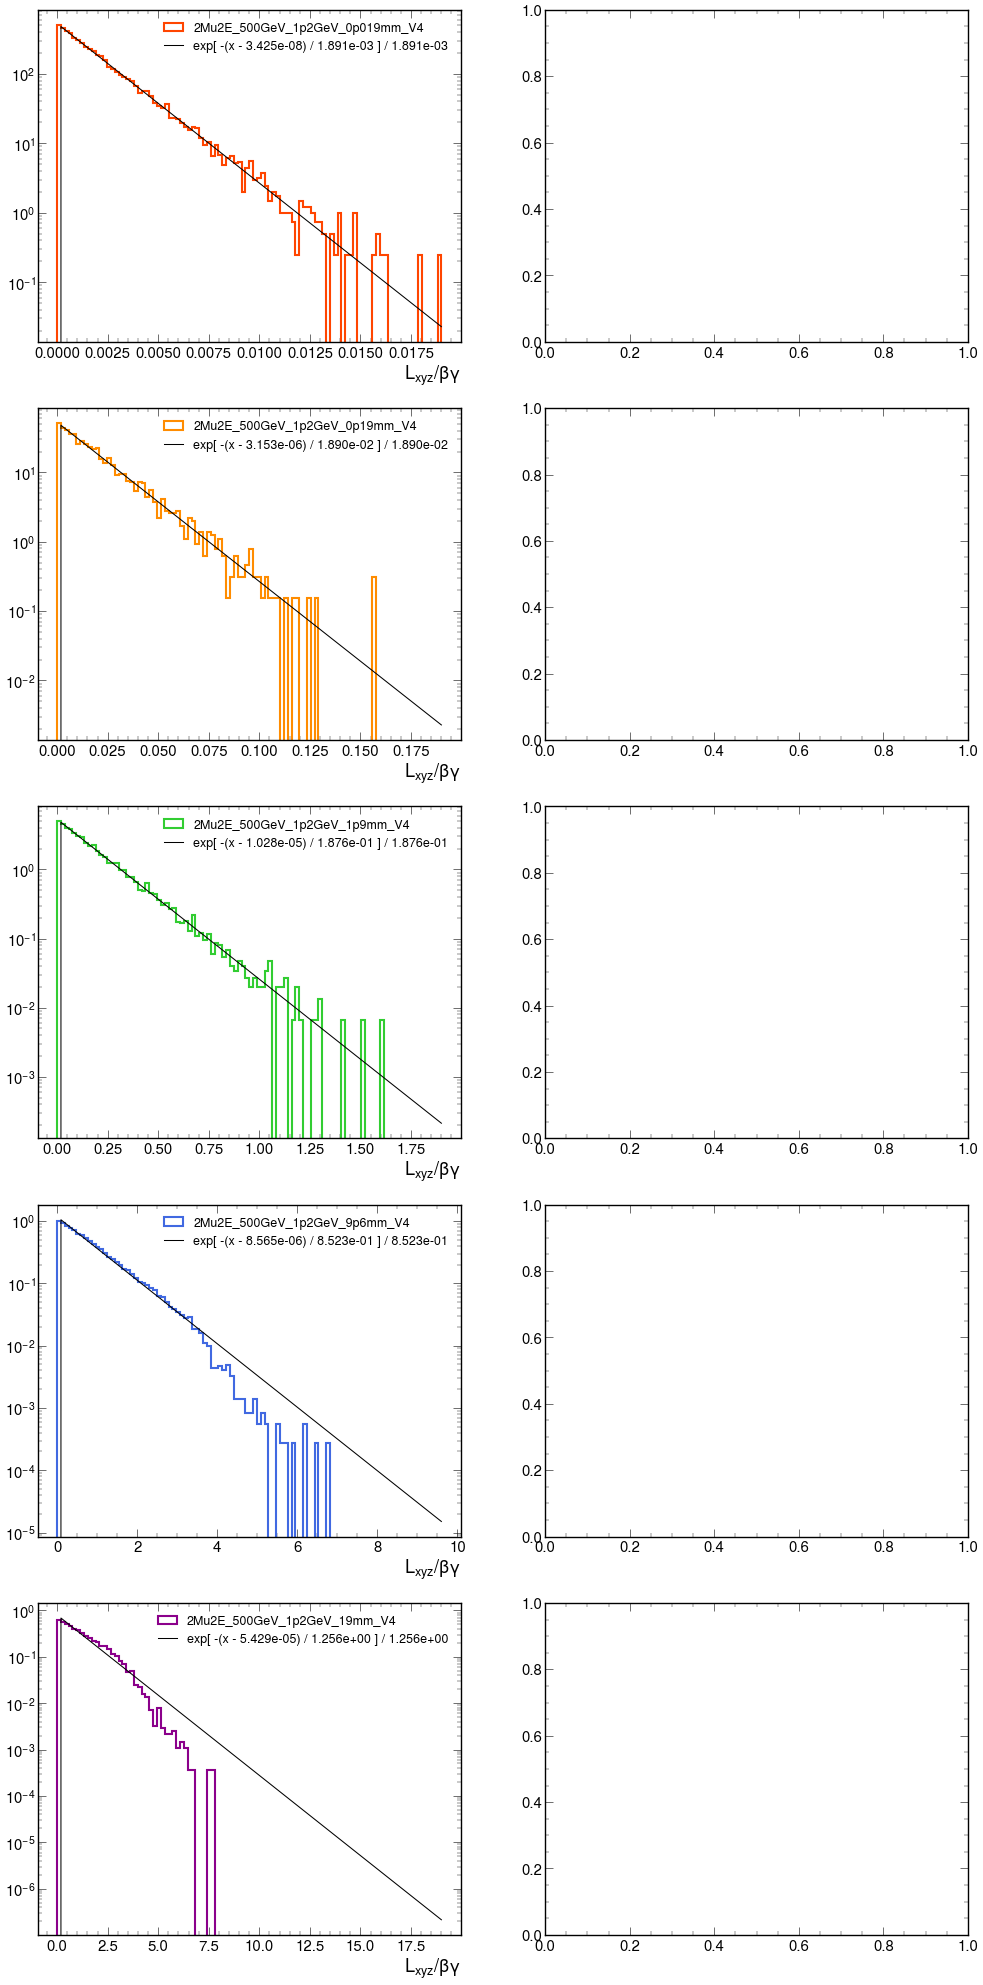

In [9]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(5, 2, figsize=(24, 50)) 

plotting_2mu2e(events_off, "2Mu2E_500GeV_1p2GeV_0p019mm", 0.019,0,0, "orangered")
#plotting_4mu(events_pri, "4Mu_500GeV_1p2GeV_0p019mm", 0.08,0,1, "orangered")

plotting_2mu2e(events_off, "2Mu2E_500GeV_1p2GeV_0p19mm", 0.19,1,0, "darkorange")
#plotting_4mu(events_pri, "4Mu_500GeV_1p2GeV_0p19mm", 0.8,1,1, "darkorange")

plotting_2mu2e(events_off, "2Mu2E_500GeV_1p2GeV_1p9mm", 1.9,2,0, "limegreen")
#plotting_4mu(events_pri, "4Mu_500GeV_1p2GeV_1p9mm", 8,2,1, "limegreen")

plotting_2mu2e(events_off, "2Mu2E_500GeV_1p2GeV_9p6mm", 9.6,3,0, "royalblue")
#plotting_4mu(events_pri, "4Mu_500GeV_1p2GeV_9p6mm", 40,3,1, "royalblue")

plotting_2mu2e(events_off, "2Mu2E_500GeV_1p2GeV_19mm", 19,4,0, "darkmagenta")
#plotting_4mu(events_pri, "4Mu_500GeV_1p2GeV_19mm", 80,4,1, "darkmagenta")

In [ ]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(5, 2, figsize=(24, 50)) 

plotting_2mu2e(events_off, "2Mu2E_500GeV_5GeV_0p08mm", 0.08,0,0, "orangered")
plotting_4mu(events_pri, "4Mu_500GeV_5GeV_0p08mm", 0.08,0,1, "orangered")

plotting_2mu2e(events_off, "2Mu2E_500GeV_5GeV_0p8mm", 0.8,1,0, "darkorange")
plotting_4mu(events_pri, "4Mu_500GeV_5GeV_0p8mm", 0.8,1,1, "darkorange")

plotting_2mu2e(events_off, "2Mu2E_500GeV_5GeV_8mm", 8,2,0, "limegreen")
plotting_4mu(events_pri, "4Mu_500GeV_5GeV_8mm", 8,2,1, "limegreen")

plotting_2mu2e(events_off, "2Mu2E_500GeV_5GeV_40mm", 40,3,0, "royalblue")
plotting_4mu(events_pri, "4Mu_500GeV_5GeV_40mm", 40,3,1, "royalblue")

plotting_2mu2e(events_off, "2Mu2E_500GeV_5GeV_80mm", 80,4,0, "darkmagenta")
plotting_4mu(events_pri, "4Mu_500GeV_5GeV_80mm", 80,4,1, "darkmagenta")